In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv"

!wget $data

--2021-10-20 06:56:20--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.2’

AB_NYC_2019.csv.2   100%[===================>]   6.75M  18.1MB/s    in 0.4s    

2021-10-20 06:56:21 (18.1 MB/s) - ‘AB_NYC_2019.csv.2’ saved [7077973/7077973]



In [6]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)
df_copy = df.copy()

#### Apply the log tranform to price
#### Do train/validation/test split with 60%/20%/20% distribution.
#### Use the train_test_split function and set the random_state parameter to 1

In [7]:
df.price = np.log1p(df.price.values)

In [8]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [11]:
del df_train['price']
del df_val['price']
del df_test['price']

#### Now, use DictVectorizer to turn train and validation into matrices:

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

In [13]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

### Question 1

#### Let's train a decision tree regressor to predict the price variable. 
#### Train a model with max_depth=1

In [17]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



#### Q1: room_type

### Question 2
##### Train a random forest model with these parameters:  n_estimators=10,  random_state=1, n_jobs=-1 (optional - to make training faster)

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [23]:
y_pred = rf.predict(X_val)

In [24]:
rmse(y_val, y_pred)

0.4655526503172463

#### RMSE : 0.4655526503172463

### Question 3
##### Experimenting with n_estimators param

In [21]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    r_score = rmse(y_val, y_pred)
    scores.append((n, r_score.round(3)))

scores

[(10, 0.466),
 (20, 0.455),
 (30, 0.449),
 (40, 0.448),
 (50, 0.447),
 (60, 0.446),
 (70, 0.446),
 (80, 0.445),
 (90, 0.445),
 (100, 0.444),
 (110, 0.444),
 (120, 0.444),
 (130, 0.444),
 (140, 0.444),
 (150, 0.444),
 (160, 0.444),
 (170, 0.444),
 (180, 0.444),
 (190, 0.444),
 (200, 0.444)]

#### RMSE stops improving after 10

### Question 4
#### Along with n_estimators try tuning for max_depth parameter

In [22]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        r_score = rmse(y_val, y_pred)
        scores.append((d, n, r_score.round(3)))

scores

[(10, 10, 0.448),
 (10, 20, 0.447),
 (10, 30, 0.445),
 (10, 40, 0.445),
 (10, 50, 0.445),
 (10, 60, 0.445),
 (10, 70, 0.445),
 (10, 80, 0.445),
 (10, 90, 0.445),
 (10, 100, 0.445),
 (10, 110, 0.445),
 (10, 120, 0.445),
 (10, 130, 0.445),
 (10, 140, 0.445),
 (10, 150, 0.445),
 (10, 160, 0.445),
 (10, 170, 0.445),
 (10, 180, 0.445),
 (10, 190, 0.445),
 (10, 200, 0.445),
 (15, 10, 0.455),
 (15, 20, 0.449),
 (15, 30, 0.445),
 (15, 40, 0.444),
 (15, 50, 0.443),
 (15, 60, 0.443),
 (15, 70, 0.442),
 (15, 80, 0.442),
 (15, 90, 0.442),
 (15, 100, 0.441),
 (15, 110, 0.441),
 (15, 120, 0.441),
 (15, 130, 0.441),
 (15, 140, 0.441),
 (15, 150, 0.441),
 (15, 160, 0.441),
 (15, 170, 0.441),
 (15, 180, 0.441),
 (15, 190, 0.441),
 (15, 200, 0.441),
 (20, 10, 0.464),
 (20, 20, 0.453),
 (20, 30, 0.448),
 (20, 40, 0.447),
 (20, 50, 0.446),
 (20, 60, 0.445),
 (20, 70, 0.445),
 (20, 80, 0.444),
 (20, 90, 0.443),
 (20, 100, 0.443),
 (20, 110, 0.443),
 (20, 120, 0.443),
 (20, 130, 0.443),
 (20, 140, 0.443),
 

In [23]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])


In [24]:
df_scores_pivot

rmse                     
max_depth        10     15     20     25
n_estimators                            
10            0.448  0.455  0.464  0.464
20            0.447  0.449  0.453  0.454
30            0.445  0.445  0.448  0.448
40            0.445  0.444  0.447  0.447
50            0.445  0.443  0.446  0.446
60            0.445  0.443  0.445  0.445
70            0.445  0.442  0.445  0.445
80            0.445  0.442  0.444  0.444
90            0.445  0.442  0.443  0.444
100           0.445  0.441  0.443  0.443
110           0.445  0.441  0.443  0.443
120           0.445  0.441  0.443  0.443
130           0.445  0.441  0.443  0.443
140           0.445  0.441  0.443  0.443
150           0.445  0.441  0.443  0.443
160           0.445  0.441  0.443  0.443
170           0.445  0.441  0.442  0.443
180           0.445  0.441  0.443  0.443
190           0.445  0.441  0.443  0.443
200           0.445  0.441  0.442  0.443

<AxesSubplot:xlabel='None-max_depth', ylabel='n_estimators'>

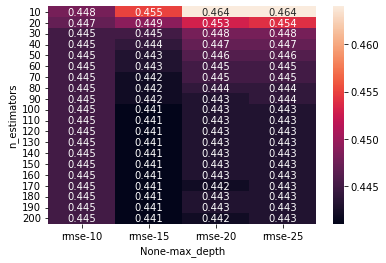

In [25]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [26]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
r_score_with_20 = rmse(y_val, y_pred)
r_score_with_20

0.46355978561111005

In [27]:
rf = RandomForestRegressor(n_estimators=10, max_depth=25, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
r_score_with_25 = rmse(y_val, y_pred)
r_score_with_25

0.46381573899567247

#### Without rounding max_depth=25 gives the best rmse score

#### Change the seed of the model to see if it impacts anything

In [28]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=10, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
r_score_with_20 = rmse(y_val, y_pred)
print('r_score_with_20',r_score_with_20)

rf = RandomForestRegressor(n_estimators=10, max_depth=25, random_state=10, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
r_score_with_25 = rmse(y_val, y_pred)
print('r_score_with_25',r_score_with_25)


r_score_with_20 0.4569389095210444
r_score_with_25 0.46171701642335145


#### max_depth=25 seems to be the best

### Question 5
#### Finding the feature importance of the tree based model

In [29]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

In [30]:
pd_series = pd.Series(feature_importances,dv.get_feature_names())
pd_series
pd_series.index

Index(['availability_365', 'calculated_host_listings_count', 'latitude',
       'longitude', 'minimum_nights', 'neighbourhood_group=Bronx',
       'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan',
       'neighbourhood_group=Queens', 'neighbourhood_group=Staten Island',
       'number_of_reviews', 'reviews_per_month', 'room_type=Entire home/apt',
       'room_type=Private room', 'room_type=Shared room'],
      dtype='object')

In [65]:
df_importances = pd.DataFrame({'feature':pd_series.index, 'importance':pd_series.values})
df_importances.sort_values('importance',ascending=False)

,feature,importance
12,room_type=Entire home/apt,0.393678
2,latitude,0.150191
3,longitude,0.145244
0,availability_365,0.079998
4,minimum_nights,0.053678
11,reviews_per_month,0.053043
10,number_of_reviews,0.045969
7,neighbourhood_group=Manhattan,0.033247
1,calculated_host_listings_count,0.031530
13,room_type=Private room,0.006639


#### Feature room_type=Entire home/apt seems to be of more importance

### Question 6
#### Train an XGBoost model

In [2]:
conda install -c conda-forge xgboost


Solving environment: done

## Package Plan ##

  environment location: /usr/local/anaconda3/envs/ml-zoomcamp

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2021.10.8  |       h033912b_0         139 KB  conda-forge
    certifi-2021.10.8          |   py38h50d1736_0         145 KB  conda-forge
    libxgboost-1.4.2           |       h4a89273_0         2.1 MB  conda-forge
    openssl-1.1.1l             |       h0d85af4_0         1.9 MB  conda-forge
    py-xgboost-1.4.2           |   py38h50d1736_0         142 KB  conda-forge
    xgboost-1.4.2              |   py38hbb4f172_0          11 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.4 MB

The following NEW packages w

In [3]:
import xgboost as xgb

In [25]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [28]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [29]:
s = output.stdout
print(s[:100])

[0]	train-rmse:3.02617	val-rmse:3.02654
[1]	train-rmse:2.14522	val-rmse:2.14747
[2]	train-rmse:1.537


In [30]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)



In [31]:
s = output.stdout
print(s[:100])

[0]	train-rmse:3.87065	val-rmse:3.86962
[1]	train-rmse:3.49008	val-rmse:3.48943
[2]	train-rmse:3.148


In [32]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [33]:
s = output.stdout
print(s[:100])

[0]	train-rmse:4.25174	val-rmse:4.25010
[1]	train-rmse:4.20979	val-rmse:4.20823
[2]	train-rmse:4.168


#### Lower RMSE value is obtained for eta = 0.3